## JuTrack Integration

In [67]:
import numpy as np
import pandas as pd
from scipy.constants import c, e, physical_constants

from synapticTrack.beam import Beam, BeamDataIO
from synapticTrack.visualizations import *

## Compute Beam Center

In [2]:
def compute_beam_center(beam_df: pd.DataFrame) -> pd.Series:
    """
    Computes the beam center (centroid) assuming equal particle weights.

    Args:
        beam_df (pd.DataFrame): DataFrame with beam particle coordinates.

    Returns:
        pd.Series: Mean values for each numeric column (beam center).
    """
    if beam_df.empty:
        raise ValueError("Beam DataFrame is empty")

    # Select only numeric columns
    numeric_df = beam_df.select_dtypes(include='number')

    if numeric_df.empty:
        raise ValueError("Beam DataFrame contains no numeric data")

    return numeric_df.mean()

In [3]:
def array_to_dataframe(array: np.ndarray, columns: list = None) -> pd.DataFrame:
    """
    Converts a NumPy array to a Pandas DataFrame.

    Args:
        array (np.ndarray): The input array of shape (n, m).
        columns (list, optional): List of column names. Must match the number of columns in the array.

    Returns:
        pd.DataFrame: The resulting DataFrame.
    """
    if not isinstance(array, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    
    if columns is not None and len(columns) != array.shape[1]:
        raise ValueError("Length of columns does not match number of array columns.")
    
    return pd.DataFrame(array, columns=columns)

### Track Input Beam Distribution

In [4]:
base_dir = '/home/cspark/Work/projects/orbit_correction/input_beam'
filename = base_dir + '/' + 'coord.out'

beam_io = BeamDataIO() 
beam = beam_io.read(code='track', filename=filename, mass_number=40, charge_state=8, beam_current=0)

x  = beam.x
xp = beam.xp
y  = beam.y
yp = beam.yp
dt = beam.dt
dW = beam.dW

In [5]:
beam.state

,Nseed,iq,dt,dW,x,xp,y,yp
0,0,1,0.0000,-3.543100e-10,0.00000,0.000000,0.00000,0.00000
1,0,1,0.3688,-1.729900e-06,3.64630,0.009006,-5.48030,3.67950
2,0,1,-4.1981,-1.226300e-06,-0.49758,3.552800,-8.43420,2.40290
3,0,1,-6.1599,-2.726600e-06,-0.14469,3.064900,-4.52100,3.18300
4,0,1,-5.7163,-2.263800e-07,-5.69520,3.185900,0.89529,-2.47710
...,...,...,...,...,...,...,...,...
9996,0,1,9.7589,1.559600e-06,3.23200,-2.690800,2.83230,1.66500
9997,0,1,4.0432,-1.363000e-10,-4.31440,3.796700,1.05720,0.21555
9998,0,1,-2.9019,-1.613500e-06,3.23680,-5.662900,4.65420,-3.35200
9999,0,1,5.5605,3.090700e-06,-0.73726,3.854000,-3.29030,-4.44810


### Track to JuTrack Conversion of Input Beam Distribution

In [6]:
def convert_to_jutrack_coordinates(beam_state: pd.DataFrame, mass_number: int, charge_state: int, reference_energy_MeVu: float) -> pd.DataFrame:
    """
    Converts a DataFrame of beam coordinates from synapticTrack to JuTrack format.

    Args:
        beam_state (pd.DataFrame): DataFrame with columns ['x', 'xp', 'y', 'yp', 'dt', 'dW'].
        mass_number (int): Mass number (A).
        charge_state (int): Charge state (Z).
        reference_energy_MeVu (float): Reference kinetic energy in MeV/u.

    Returns:
        pd.DataFrame: Converted coordinates in JuTrack format.
    """
    # Convert position units: mm -> m
    x = beam_state['x'].values * 1e-3
    y = beam_state['y'].values * 1e-3

    # Convert angles from mrad to rad
    xp = beam_state['xp'].values * 1e-3
    yp = beam_state['yp'].values * 1e-3

    dt = beam_state['dt'].values
    dW = beam_state['dW'].values

    amu = physical_constants['atomic mass constant energy equivalent in MeV'][0]
    
    # Reference mass and energy
    E0 = mass_number * amu                    # total rest mass energy in MeV
    gamma0 = 1 + reference_energy_MeVu / amu
    beta0 = np.sqrt(1 - 1 / gamma0**2)
    p0 = gamma0 * beta0 * E0  # Reference momentum [MeV/c]

    # Actual energy
    kinetic_energy = mass_number * (reference_energy_MeVu + dW)  # MeV/u
    gamma = 1 + kinetic_energy / E0
    beta = np.sqrt(1 - 1 / gamma**2)
    p = gamma * beta * E0         # MeV/c

    delta = (p - p0) / p0

    # Initial px/p0, py/p0 (approximate)
    px_p0 = xp
    py_p0 = yp

    # Enforce longitudinal momentum constraint
    pz_p0 = np.sqrt((1 + delta)**2 - px_p0**2 - py_p0**2)
    #pz_p0 = np.sqrt(np.clip((1 + delta)**2 - px_p0**2 - py_p0**2, epsilon, None))

    # Now refine px/p0 and py/p0 using better scaling with pz
    px_p0 = xp * pz_p0
    py_p0 = yp * pz_p0

    # z coordinate in JuTrack: -βc dt
    z = - beta0 * c * dt

    # Compose DataFrame
    jutrack_df = pd.DataFrame({
        "x": x,
        "px_p0": px_p0,
        "y": y,
        "py_p0": py_p0,
        "z": z,
        "delta": delta
    })

    return jutrack_df

### Test

In [7]:
beam_state = pd.DataFrame({
    'x': [1.0],     # mm
    'xp': [10.0],   # mrad
    'y': [2.0],     # mm
    'yp': [-5.0],   # mrad
    'dt': [1e-9],   # sec
    'dW': [0.001]   # MeV/u
})

In [8]:
beam_state

,x,xp,y,yp,dt,dW
0,1.0,10.0,2.0,-5.0,1.000000e-09,0.001


In [9]:
A = 40         # mass number
Z = 8          # charge state
Ek = 0.01      # kinetic energy in MeV/u
jutrack_coords = convert_to_jutrack_coordinates(beam_state, A, Z, Ek)
print(jutrack_coords)

       x     px_p0      y     py_p0         z     delta
0  0.001  0.010487  0.002 -0.005244 -0.001389  0.048809


### Track to JuTrack Conversion of Input Beam Distribution

In [10]:
jutrack_coords = convert_to_jutrack_coordinates(beam.state, A, Z, Ek)
print(jutrack_coords)

              x     px_p0         y     py_p0             z         delta
0      0.000000  0.000000  0.000000  0.000000 -0.000000e+00 -1.771593e-08
1      0.003646  0.000009 -0.005480  0.003679 -5.123103e+05 -8.649920e-05
2     -0.000498  0.003553 -0.008434  0.002403  5.831697e+06 -6.131721e-05
3     -0.000145  0.003064 -0.004521  0.003183  8.556887e+06 -1.363400e-04
4     -0.005695  0.003186  0.000895 -0.002477  7.940670e+06 -1.131912e-05
...         ...       ...       ...       ...           ...           ...
9996   0.003232 -0.002691  0.002832  0.001665 -1.355636e+07  7.797738e-05
9997  -0.004314  0.003797  0.001057  0.000216 -5.616521e+06 -6.815412e-09
9998   0.003237 -0.005662  0.004654 -0.003352  4.031109e+06 -8.067868e-05
9999  -0.000737  0.003855 -0.003290 -0.004449 -7.724244e+06  1.545239e-04
10000  0.002584 -0.001823 -0.000448  0.003796 -3.198605e+06  2.231113e-04

[10001 rows x 6 columns]


In [11]:
xjt = jutrack_coords['x']
xpjt = jutrack_coords['px_p0']
yjt = jutrack_coords['y']
ypjt = jutrack_coords['py_p0']
z = jutrack_coords['z']
delta = jutrack_coords['delta']

centers = compute_beam_center(jutrack_coords)
print(centers)
x0 = centers['x']
xp0 = centers['px_p0']

x        1.436370e-05
px_p0   -6.302202e-07
y       -2.236773e-07
py_p0   -4.468169e-09
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


### Phasespace Plots for JuTrack Beam Distribution

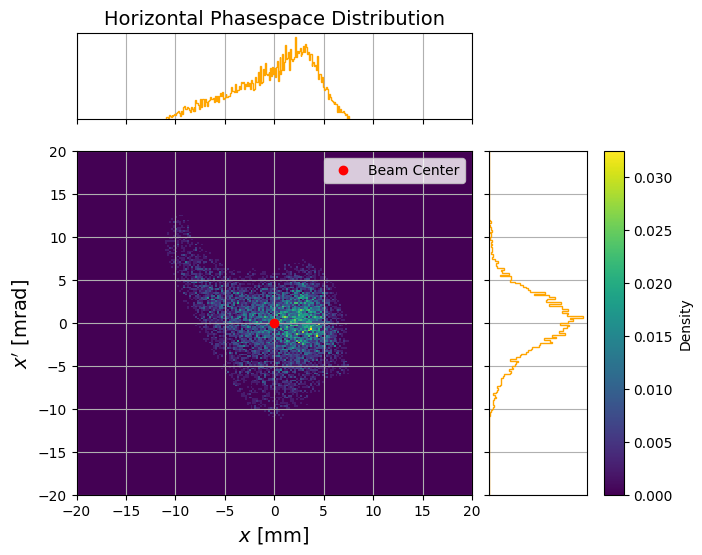

In [12]:
phasespace_plot(xjt*1e3, xpjt*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -20, 20], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$x^{\prime}$ [mrad]",
                nbins=200, projection=0, density=True, cmap='viridis', figname=None)

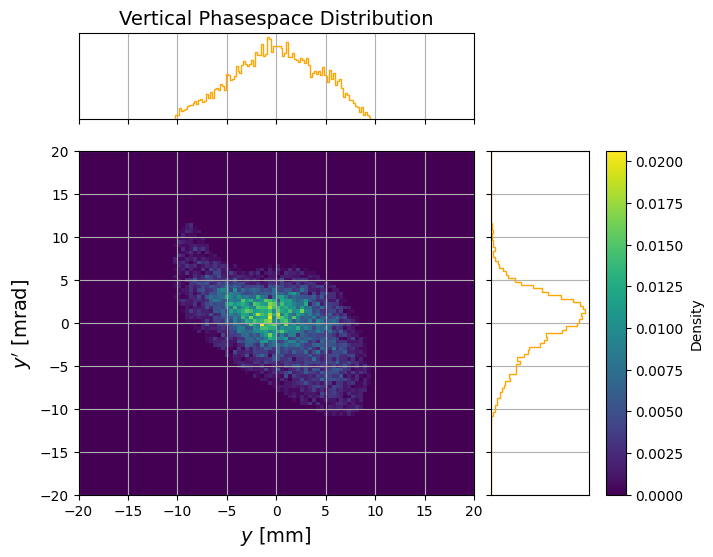

In [13]:
phasespace_plot(yjt*1e3, ypjt*1e3, xyrange=[-20, 20, -20, 20], title='Vertical Phasespace Distribution', 
                xlabel=r'$y$ [mm]', ylabel=r"$y^{\prime}$ [mrad]",
                nbins=100, projection=0, density=True, cmap='viridis', figname=None)

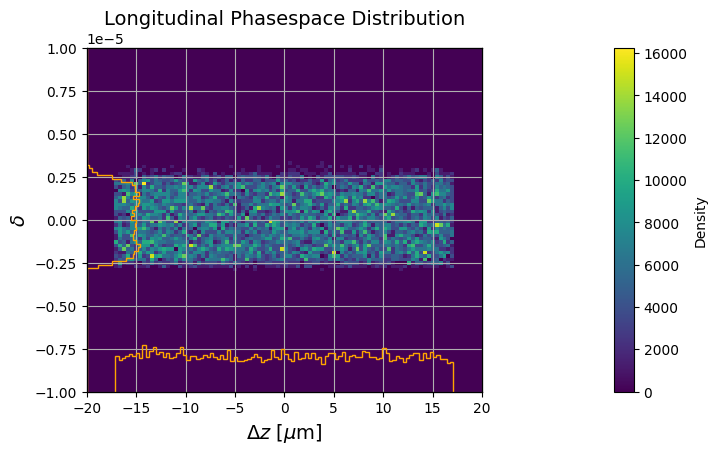

In [14]:
phasespace_plot(z*1e-6, delta*1e-2, xyrange=[-20, 20, -10e-6, 10e-6], title='Longitudinal Phasespace Distribution', 
                xlabel=r'$\Delta z$ [$\mu$m]', ylabel=r"$\delta$", 
                nbins=100, projection=7, density=True, cmap='viridis', figname=None)

## Save beam distribution for JuTrack

In [15]:
def save_r_matrix(jutrack_df: pd.DataFrame, filename: str):
    """
    Save the JuTrack-compatible r matrix to a plain text file.

    Args:
        jutrack_df (pd.DataFrame): DataFrame with JuTrack coordinates.
        filename (str): Path to save the r matrix (.dat or .txt).
    """
    jutrack_df.to_csv(filename, sep=' ', header=False, index=False, float_format='%.12e')

In [16]:
save_r_matrix(jutrack_coords, "r_matrix.dat")

## Julia Integration

In [17]:
# PATH Environment Setting for julia
%env PATH="$HOME/.pyenv/bin:/opt/julia-1.10.4/bin/:$PATH"

# the number of threads for julia computing
%env JULIA_NUM_THREADS = 2

env: PATH="$HOME/.pyenv/bin:/opt/julia-1.10.4/bin/:$PATH"
env: JULIA_NUM_THREADS=2


In [18]:
from julia import Main
Main.eval("using JuTrack")

In [19]:
jubeam = Main.eval('include("beam.jl")')

In [20]:
julattice = Main.eval('include("lebt.jl")')

### Initial Beam Distribution

In [21]:
beam_state0 = Main.beam.r
x = beam_state0[:,0]
xp = beam_state0[:,1]
y = beam_state0[:,2]
yp = beam_state0[:,3]
z = beam_state0[:,4]
delta = beam_state0[:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(beam_state0, columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x        1.436370e-05
px/p0   -6.302202e-07
y       -2.236773e-07
py/p0   -4.468169e-09
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


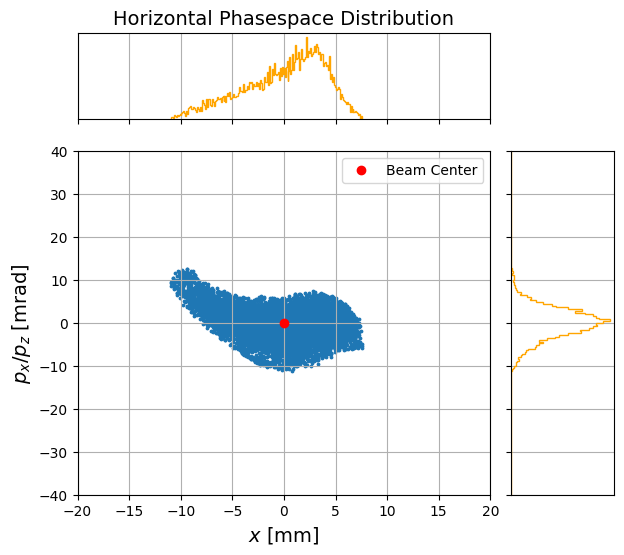

In [22]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname=None)

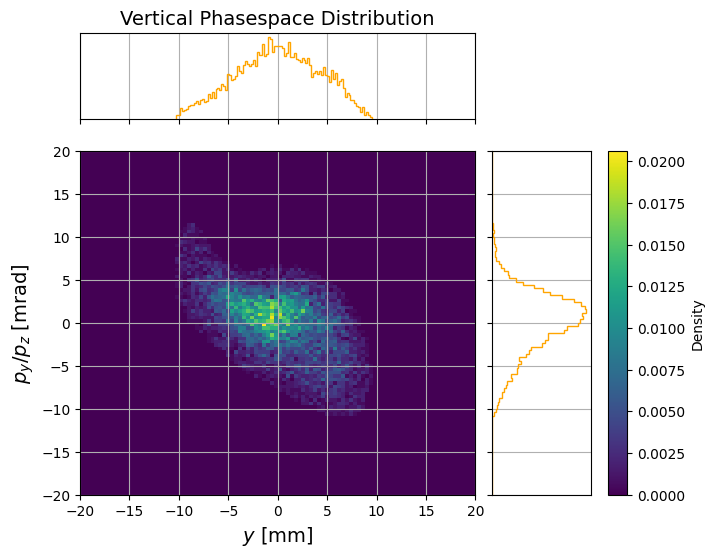

In [23]:
phasespace_plot(y*1e3, yp*1e3, xyrange=[-20, 20, -20, 20], title='Vertical Phasespace Distribution', 
                xlabel=r'$y$ [mm]', ylabel=r"$p_y / p_z$ [mrad]",
                nbins=100, projection=0, density=True, cmap='viridis', figname=None)

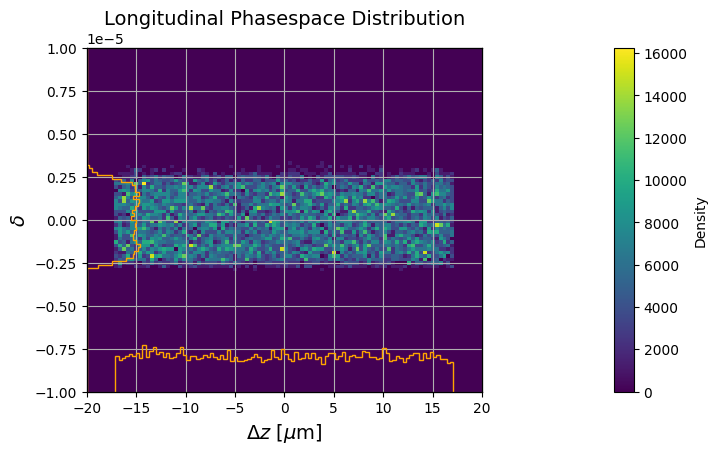

In [24]:
phasespace_plot(z*1e-6, delta*1e-2, xyrange=[-20, 20, -10e-6, 10e-6], title='Longitudinal Phasespace Distribution', 
                xlabel=r'$\Delta z$ [$\mu$m]', ylabel=r"$\delta$", 
                nbins=100, projection=7, density=True, cmap='viridis', figname=None)

### After LEBT Beam Distribution

In [25]:
Main.eval('linepass!(LEBT, beam)')

In [26]:
beam_state = Main.beam.r
x = beam_state[:,0]
xp = beam_state[:,1]
y = beam_state[:,2]
yp = beam_state[:,3]
z = beam_state[:,4]
delta = beam_state[:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(beam_state, columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x        3.907350e-06
px/p0    4.984541e-05
y        1.092476e-07
py/p0    4.479533e-06
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


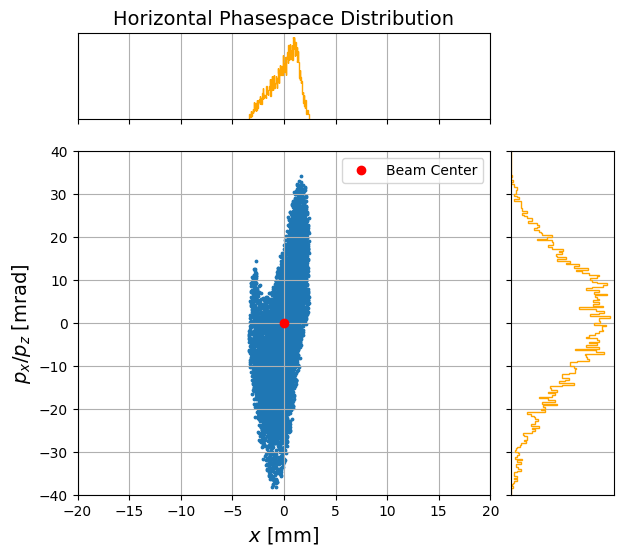

In [27]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname=None)

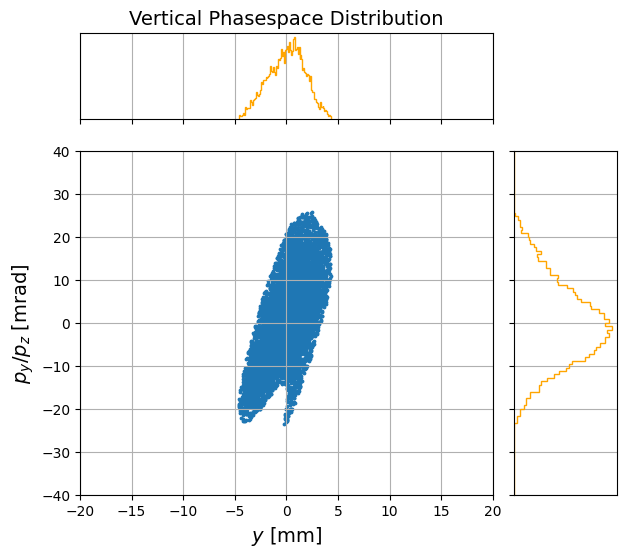

In [28]:
phasespace_plot(y*1e3, yp*1e3, xyrange=[-20, 20, -40, 40], title='Vertical Phasespace Distribution', 
                xlabel=r'$y$ [mm]', ylabel=r"$p_y / p_z$ [mrad]",
                nbins=100, projection=0, density=False, cmap='viridis', figname=None)

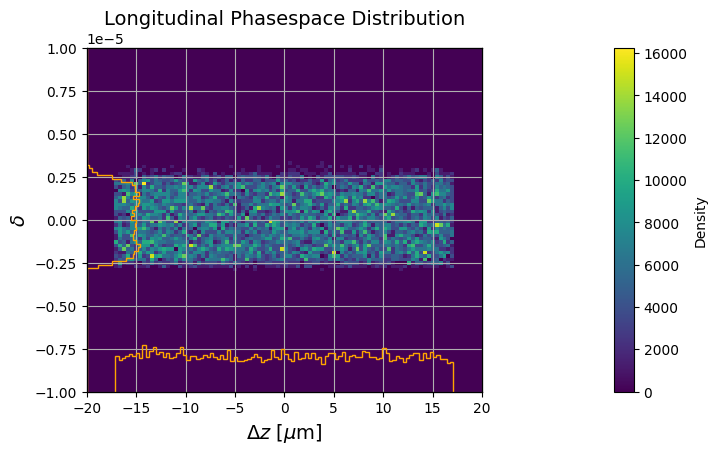

In [29]:
phasespace_plot(z*1e-6, delta*1e-2, xyrange=[-20, 20, -10e-6, 10e-6], title='Longitudinal Phasespace Distribution', 
                xlabel=r'$\Delta z$ [$\mu$m]', ylabel=r"$\delta$", 
                nbins=100, projection=7, density=True, cmap='viridis', figname=None)

### Tracking

In [30]:
jubeam = Main.eval('include("beam.jl")')

In [31]:
track = Main.eval('include("./track.jl")')

WS01
AS01
WS02
WS03
WS04
D23


In [32]:
states_at_diags = Main.states_at_diags

In [33]:
x = states_at_diags["WS01"][:,0]
xp = states_at_diags["WS01"][:,1]
y = states_at_diags["WS01"][:,2]
yp = states_at_diags["WS01"][:,3]
z = states_at_diags["WS01"][:,4]
delta = states_at_diags["WS01"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["WS01"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x       -2.105735e-05
px/p0   -2.697304e-05
y       -7.793219e-07
py/p0   -7.860623e-07
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


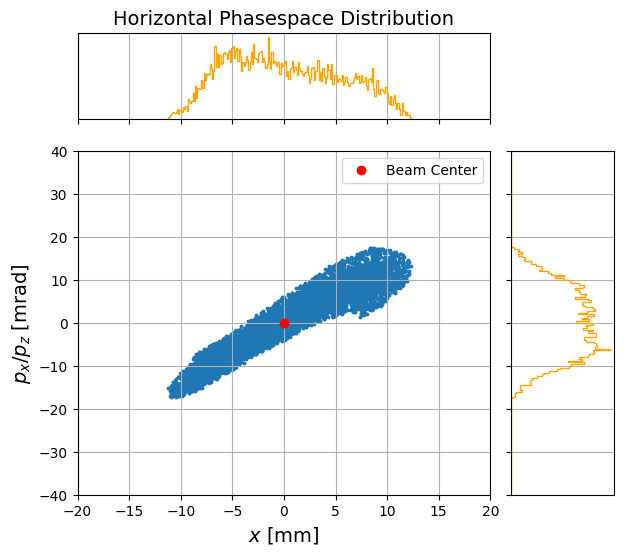

In [34]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname=None)

In [35]:
x = states_at_diags["AS01"][:,0]
xp = states_at_diags["AS01"][:,1]
y = states_at_diags["AS01"][:,2]
yp = states_at_diags["AS01"][:,3]
z = states_at_diags["AS01"][:,4]
delta = states_at_diags["AS01"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["AS01"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x       -1.323249e-05
px/p0    1.339688e-05
y       -9.904345e-07
py/p0    7.087804e-08
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


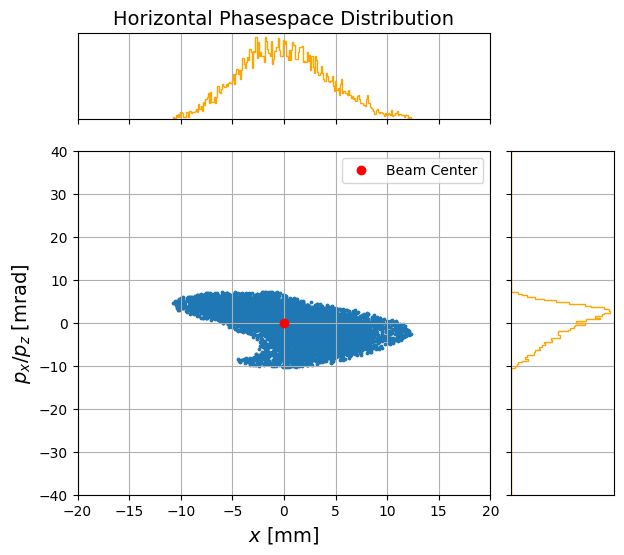

In [36]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname=None)

In [37]:
x = states_at_diags["WS02"][:,0]
xp = states_at_diags["WS02"][:,1]
y = states_at_diags["WS02"][:,2]
yp = states_at_diags["WS02"][:,3]
z = states_at_diags["WS02"][:,4]
delta = states_at_diags["WS02"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["WS02"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x       -4.227149e-06
px/p0   -3.385729e-05
y        9.557482e-07
py/p0    6.479427e-08
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


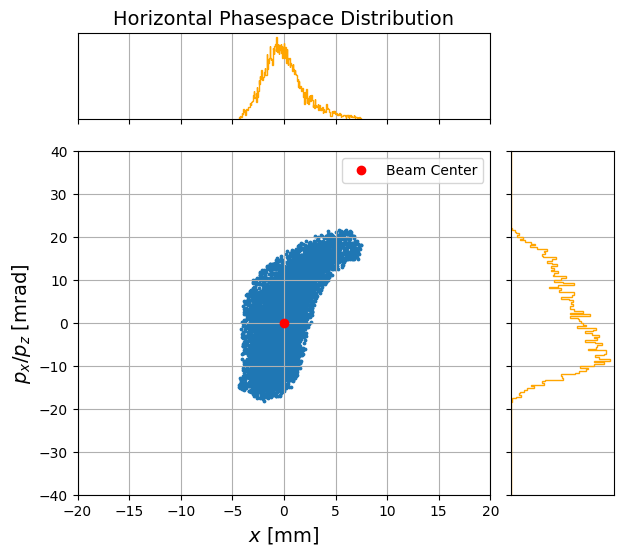

In [38]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname=None)

In [39]:
x = states_at_diags["WS03"][:,0]
xp = states_at_diags["WS03"][:,1]
y = states_at_diags["WS03"][:,2]
yp = states_at_diags["WS03"][:,3]
z = states_at_diags["WS03"][:,4]
delta = states_at_diags["WS03"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["WS03"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x       -2.315449e-05
px/p0    2.287617e-06
y       -1.749485e-07
py/p0   -1.753331e-06
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


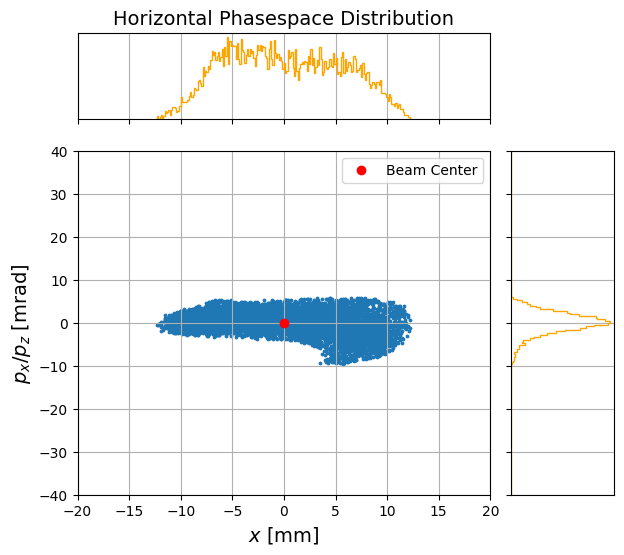

In [40]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname=None)

In [41]:
x = states_at_diags["WS04"][:,0]
xp = states_at_diags["WS04"][:,1]
y = states_at_diags["WS04"][:,2]
yp = states_at_diags["WS04"][:,3]
z = states_at_diags["WS04"][:,4]
delta = states_at_diags["WS04"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["WS04"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x       -2.246814e-05
px/p0    3.158350e-06
y       -1.546606e-06
py/p0   -1.875637e-06
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


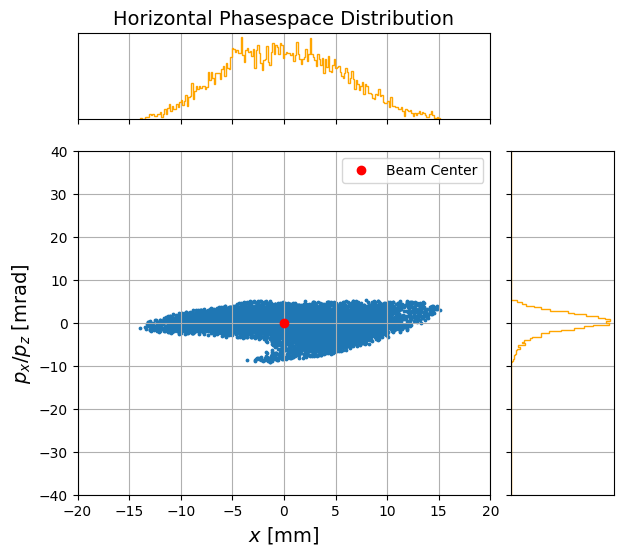

In [42]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname=None)

In [43]:
x = states_at_diags["D23"][:,0]
xp = states_at_diags["D23"][:,1]
y = states_at_diags["D23"][:,2]
yp = states_at_diags["D23"][:,3]
z = states_at_diags["D23"][:,4]
delta = states_at_diags["D23"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["D23"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x        3.907350e-06
px/p0    4.984541e-05
y        1.092476e-07
py/p0    4.479533e-06
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


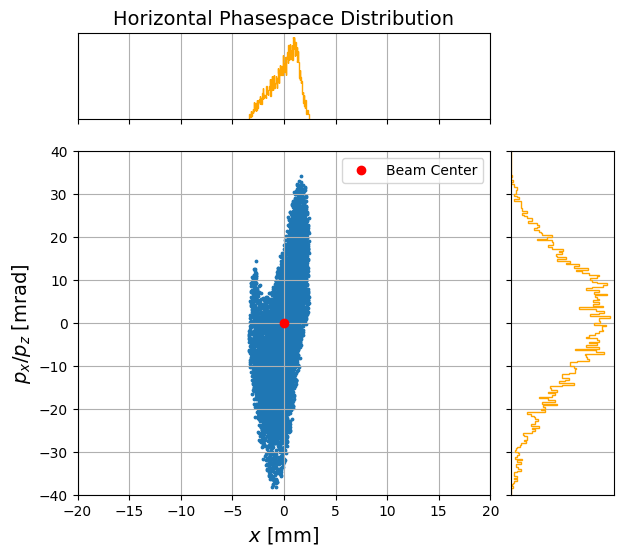

In [44]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname=None)

### Tracking with Space Charge Effects

In [45]:
jubeam = Main.eval('include("./beam.jl")')
julattice = Main.eval('include("./lebt_sc.jl")')

In [46]:
track = Main.eval('include("./track_sc.jl")')

WS01
AS01
WS02
WS03
WS04
D23SC


In [47]:
states_at_diags = Main.states_at_diags

In [48]:
x = states_at_diags["WS01"][:,0]
xp = states_at_diags["WS01"][:,1]
y = states_at_diags["WS01"][:,2]
yp = states_at_diags["WS01"][:,3]
z = states_at_diags["WS01"][:,4]
delta = states_at_diags["WS01"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["WS01"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x       -2.105749e-05
px/p0   -2.697194e-05
y       -7.793219e-07
py/p0   -7.860622e-07
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


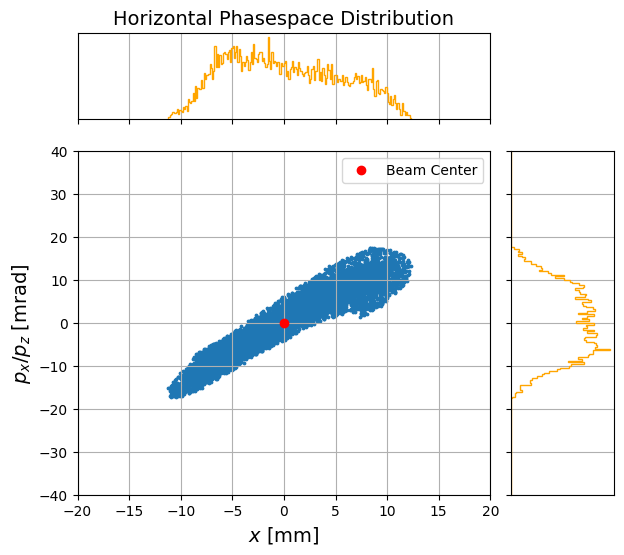

In [49]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname='ju1.png')

In [50]:
x = states_at_diags["AS01"][:,0]
xp = states_at_diags["AS01"][:,1]
y = states_at_diags["AS01"][:,2]
yp = states_at_diags["AS01"][:,3]
z = states_at_diags["AS01"][:,4]
delta = states_at_diags["AS01"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["AS01"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x       -1.323064e-05
px/p0    1.339792e-05
y       -9.904986e-07
py/p0    7.083920e-08
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


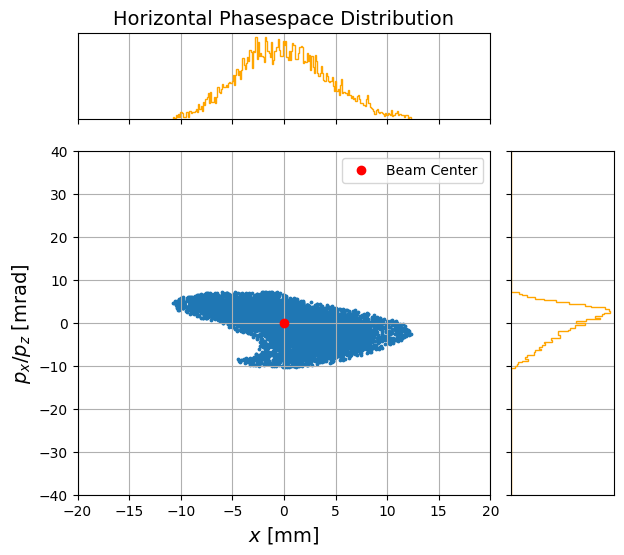

In [51]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname='ju2.png')

In [52]:
x = states_at_diags["WS02"][:,0]
xp = states_at_diags["WS02"][:,1]
y = states_at_diags["WS02"][:,2]
yp = states_at_diags["WS02"][:,3]
z = states_at_diags["WS02"][:,4]
delta = states_at_diags["WS02"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["WS02"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x       -4.229927e-06
px/p0   -3.385750e-05
y        9.558038e-07
py/p0    6.485254e-08
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


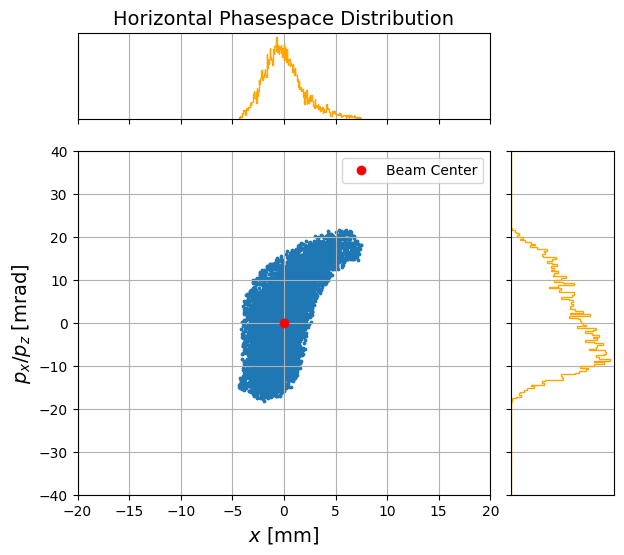

In [53]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname='ju3.png')

In [54]:
x = states_at_diags["WS03"][:,0]
xp = states_at_diags["WS03"][:,1]
y = states_at_diags["WS03"][:,2]
yp = states_at_diags["WS03"][:,3]
z = states_at_diags["WS03"][:,4]
delta = states_at_diags["WS03"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["WS03"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x       -2.315188e-05
px/p0    2.291444e-06
y       -1.749340e-07
py/p0   -1.753505e-06
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


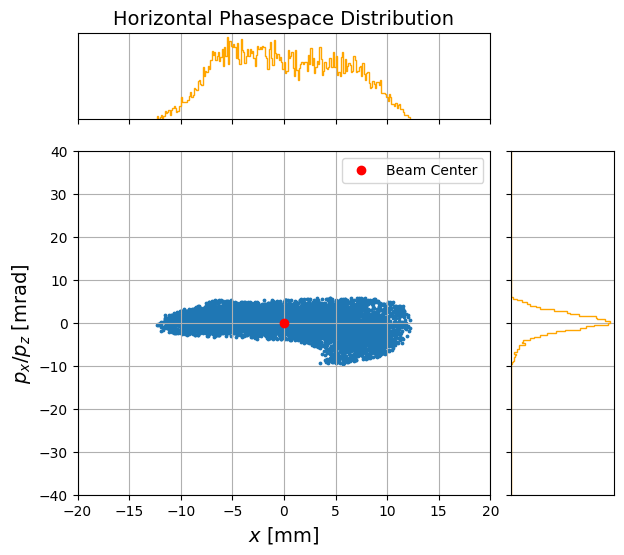

In [55]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname='ju4.png')

In [56]:
x = states_at_diags["WS04"][:,0]
xp = states_at_diags["WS04"][:,1]
y = states_at_diags["WS04"][:,2]
yp = states_at_diags["WS04"][:,3]
z = states_at_diags["WS04"][:,4]
delta = states_at_diags["WS04"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["WS04"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x       -2.246244e-05
px/p0    3.161758e-06
y       -1.546730e-06
py/p0   -1.875824e-06
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


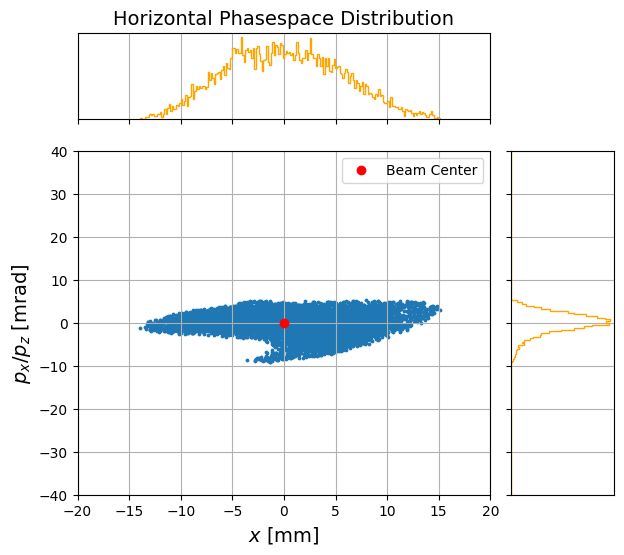

In [57]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname='ju5.png')

In [58]:
x = states_at_diags["D23SC"][:,0]
xp = states_at_diags["D23SC"][:,1]
y = states_at_diags["D23SC"][:,2]
yp = states_at_diags["D23SC"][:,3]
z = states_at_diags["D23SC"][:,4]
delta = states_at_diags["D23SC"][:,5]

columns = ['x', 'px/p0', 'y', 'py/p0', 'z', 'delta']
centers = compute_beam_center(array_to_dataframe(states_at_diags["D23SC"], columns))
print(centers)
x0 = centers['x']
xp0 = centers['px/p0']

x        3.907841e-06
px/p0    4.982987e-05
y        1.092535e-07
py/p0    4.479941e-06
z       -1.891390e+05
delta   -2.857224e-08
dtype: float64


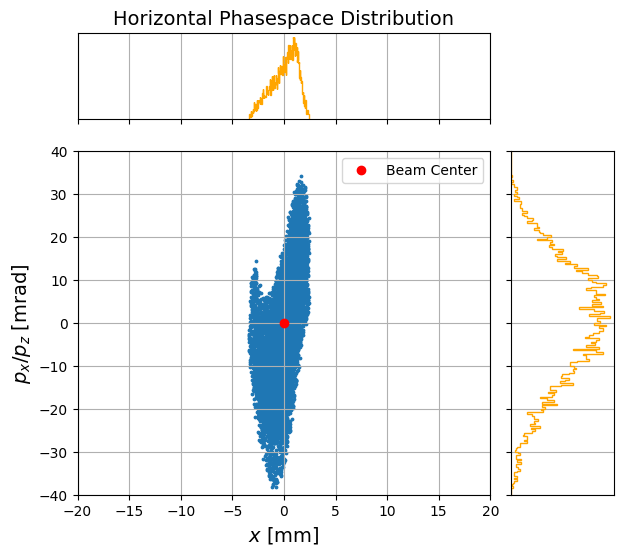

In [59]:
phasespace_plot(x*1e3, xp*1e3, x_center=x0*1e3, y_center=xp0*1e3, xyrange=[-20, 20, -40, 40], 
                title='Horizontal Phasespace Distribution', 
                xlabel=r'$x$ [mm]', ylabel=r"$p_x / p_z$ [mrad]",
                nbins=200, projection=0, density=False, cmap='viridis', figname='ju6.png')

## JuTrack Beam Distribution to synapticTrack Beam Distribution

In [60]:
jubeam = Main.eval('include("./beam.jl")')
julattice = Main.eval('include("./lebt.jl")')

In [61]:
jubeam.r

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -1.77159329e-08],
       [ 3.64630000e-03,  9.00476005e-06, -5.48030000e-03,
         3.67915682e-03, -5.12310269e+05, -8.64991965e-05],
       [-4.97580000e-04,  3.55254947e-03, -8.43420000e-03,
         2.40273056e-03,  5.83169669e+06, -6.13172088e-05],
       ...,
       [ 3.23680000e-03, -5.66232050e-03,  4.65420000e-03,
        -3.35165698e-03,  4.03110946e+06, -8.06786797e-05],
       [-7.37260000e-04,  3.85452880e-03, -3.29030000e-03,
        -4.44871031e-03, -7.72424417e+06,  1.54523892e-04],
       [ 2.58360000e-03, -1.82329056e-03, -4.48030000e-04,
         3.79581308e-03, -3.19860528e+06,  2.23111310e-04]],
      shape=(10001, 6))

In [63]:
type(jubeam.r)

numpy.ndarray

In [68]:
def jutrack_to_synaptictrack(r_matrix: np.ndarray, mass_number: int, charge_state: int, reference_energy_MeVu: float, beam_current: float) -> Beam:
    """
    Convert JuTrack beam state to synapticTrack Beam object.

    Args:
        r_matrix (np.ndarray): JuTrack beam state (N x 6).
        mass_number (int): Mass number (A).
        charge_state (int): Charge state (Z).
        reference_energy_MeVu (float): Reference kinetic energy [MeV/u].
        beam_current (float): Beam current [A].

    Returns:
        Beam: synapticTrack Beam object.
    """
    assert r_matrix.shape[1] == 6, "r_matrix must have 6 columns"

    x, px_p0, y, py_p0, z, delta = r_matrix.T

    # Convert JuTrack coordinates to synapticTrack
    amu = physical_constants['atomic mass constant energy equivalent in MeV'][0]
    E0 = mass_number * amu  # MeV
    gamma0 = 1 + reference_energy_MeVu / amu
    beta0 = np.sqrt(1 - 1 / gamma0**2)
    p0 = gamma0 * beta0 * E0  # MeV/c

    # Calculate total p from delta
    p = p0 * (1 + delta)
    gamma = np.sqrt(1 + (p / E0)**2)
    dW = (gamma - gamma0) * amu  # MeV/u

    # Estimate pz/p0
    pz_p0 = np.sqrt((1 + delta)**2 - px_p0**2 - py_p0**2)

    # Convert normalized momenta to angles
    xp = (px_p0 / pz_p0) * 1e3  # mrad
    yp = (py_p0 / pz_p0) * 1e3  # mrad

    # Convert to synapticTrack units
    x_mm = x * 1e3
    y_mm = y * 1e3
    dt = -z / (beta0 * c)

    df = pd.DataFrame({
        "x": x_mm,
        "xp": xp,
        "y": y_mm,
        "yp": yp,
        "dt": dt,
        "dW": dW
    })

    return Beam(df, mass_number, charge_state, beam_current)

In [77]:
synapticbeam = jutrack_to_synaptictrack(
    jubeam.r,
    mass_number=40,
    charge_state=8,
    reference_energy_MeVu=0.010,
    beam_current=0.0
)

print("Centroivd:")
print(synapticbeam.centroid)
print("")
print("RMS size:")
print(synapticbeam.rms_size)

Centroivd:
x     1.436370e-02
xp   -6.793683e-04
y    -2.236773e-04
yp   -2.694322e-05
dt    1.361567e-01
dW   -3.541720e-10
dtype: float64

RMS size:
x     3.878482
xp    3.542693
y     4.171719
yp    3.564111
dt    7.117605
dW    0.000003
dtype: float64


In [75]:
states_at_diags = Main.states_at_diags

In [79]:
synapticbeam_WS01 = jutrack_to_synaptictrack(
    states_at_diags["WS01"],
    mass_number=40,
    charge_state=8,
    reference_energy_MeVu=0.010,
    beam_current=0.0
)

print("Centroivd:")
print(synapticbeam_WS01.centroid)
print("")
print("RMS size:")
print(synapticbeam_WS01.rms_size)

Centroivd:
x    -2.105749e-02
xp   -2.698598e-02
y    -7.793219e-04
yp   -6.824566e-04
dt    1.361567e-01
dW   -3.541720e-10
dtype: float64

RMS size:
x      5.452553
xp     7.403706
y     12.321299
yp    11.914575
dt     7.117605
dW     0.000003
dtype: float64
